# General

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths, lombscargle
import pandas as pd
from scipy.constants import c
import os
from scipy.fft import fft, ifft, fftfreq, fftshift
from pynufft import NUFFT
from scipy.interpolate import interp1d, CubicSpline
from scipy.optimize import minimize, fsolve

print('c =', c) # speed of light in m/s
data_folder = r'c:\Users\yaniv\Yehonathan TAU\PhyChemLab\interferometry_data'
# os.chdir(data_folder)
print('Current working directory:', os.getcwd())

c = 299792458.0
Current working directory: c:\Users\yaniv\Yehonathan TAU\PhyChemLab


# Functions

In [107]:
def load_data(file_path):
    data = pd.read_excel(file_path)
    data['frequency THz'] = c / data['wavelength nm'] * 1e-3 # convert to THz
    return data

def plot_comb(data, peaks = None, type = 'freq', title = None):
    if type == 'freq':
        plt.plot(data['frequency THz'], data['intensity'])
        if peaks is not None:
            plt.plot(data['frequency THz'][peaks], data['intensity'][peaks], 'x')
        plt.xlabel('Frequency [THz]')
        plt.ylabel('Intensity')
        if title is not None:
            plt.title(title)
        else:
            plt.title('Comb Spectrum | Frequency', fontsize=16)
    elif type == 'wavel':
        plt.plot(data['wavelength nm'], data['intensity'])
        if peaks is not None:
            plt.plot(data['wavelength nm'][peaks], data['intensity'][peaks], 'x')
        plt.xlabel('Wavelength [nm]')
        plt.ylabel('Intensity')
        if title is not None:
            plt.title(title)
        else:
            plt.title('Comb Spectrum | Wavelength')
    elif type == 'both':
        fig, axs = plt.subplots(2, 1, figsize=(10, 8))
        axs[0].plot(data['frequency THz'], data['intensity'])
        if peaks is not None:
            axs[0].plot(data['frequency THz'][peaks], data['intensity'][peaks], 'x')
        axs[0].set_xlabel('Frequency (THz)')
        axs[0].set_ylabel('Intensity')
        axs[0].set_title('Comb Spectrum | Frequency', fontsize=16)

        axs[1].plot(data['wavelength nm'], data['intensity'])
        if peaks is not None:
            axs[1].plot(data['wavelength nm'][peaks], data['intensity'][peaks], 'x')
        axs[1].set_xlabel('Wavelength (nm)')
        axs[1].set_ylabel('Intensity')
        axs[1].set_title('Comb Spectrum | Wavelength', fontsize=16)
        if title is not None:
            fig.suptitle(title, fontsize=20)
        else:
            fig.suptitle('Comb Spectrum', fontsize=20)

        plt.tight_layout()
    else:
        print('Invalid plot type. Use "freq" or "wavel"')
    plt.show()

def find_peaks_comb(data,  threshold = 1000, width = 10, distance = 50):
    peaks, _ = find_peaks(data['intensity'], height = threshold, distance = distance, width = width)
    return peaks

def culc_frec_spacing(data, peaks, plot = False, toprint = False):
    frec_spacing = - np.diff(data['frequency THz'][peaks])
    frec_spacing_mean = np.mean(frec_spacing) # THz
    frec_spacing_std = np.std(frec_spacing) # THz

    delta_x = c / frec_spacing_mean * 1e-6 # convert to um
    delta_x_err = c * frec_spacing_std / frec_spacing_mean ** 2 * 1e-6 # convert to um
    
    if toprint:
        print('Mean frequency spacing: {:.3f} ± {:.3f} THz'.format(frec_spacing_mean, frec_spacing_std))
        print('Δt = {:.3f} ± {:.3f} psec\n'.format(1/ frec_spacing_mean , frec_spacing_std / frec_spacing_mean ** 2))
        print('Δx = {:.3f} ± {:.3f} μm\n'.format(delta_x, delta_x_err))

    if plot:
        plt.hist(frec_spacing, bins = 20)
        plt.xlabel('Frequency Spacing [THz]')
        plt.ylabel('Counts')
        plt.title('Frequency Spacing Histogram')
        plt.show()

    return delta_x, delta_x_err

def calc_file(file_path, plot1 = False, plot2 = False,  **kwargs):
    data = load_data(file_path)
    peaks = find_peaks_comb(data, **kwargs)
    if plot1:
        if plot1 == 'freq':
            text_type = 'Frequency'
        elif plot1 == 'wavel':
            text_type = 'Wavelength'
        else:
            text_type = 'Both'
        title = 'Comb Spectrum | ' + text_type + ' | ' + os.path.splitext(os.path.basename(file_path))[0]
        plot_comb(data, peaks, type = plot1, title = title)
    delta_x, delta_x_err = culc_frec_spacing(data, peaks, plot2, toprint= bool(plot1))
    return delta_x, delta_x_err

def extract_reflective_index(mesure_file, reference_file, d, plot = False, **kwargs): # d in um!!!
    delta_xFT_ref, delta_xFT_err_ref, delta_xFP_ref, delta_xFP_err_ref = calc_file2(reference_file, plot = plot) # um
    delta_xFT_mes, delta_xFT_err_mes, delta_xFP_mes, delta_xFP_err_mes = calc_file2(mesure_file, plot = plot,  **kwargs) # um

    l_FT = delta_xFT_mes - delta_xFT_ref # um
    l_FT_err = np.sqrt(delta_xFT_err_ref**2 + delta_xFT_err_mes**2) # um
    l_FP = delta_xFP_mes - delta_xFP_ref # um
    l_FP_err = np.sqrt(delta_xFP_err_ref**2 + delta_xFP_err_mes**2) # um

    delta_n_FT = l_FT / (2* d ) # refractive index difference FT
    delta_n_FT_err = l_FT_err / (2 * d) # refractive index difference error FT

    delta_n_FP = l_FP / (2* d ) # refractive index difference FP
    delta_n_FP_err = l_FP_err / (2 * d) # refractive index difference error FP

    n_FT = 1 + delta_n_FT # refractive index
    n_FT_err = delta_n_FT_err # refractive index error

    n_FP = 1 + delta_n_FP # refractive index
    n_FP_err = delta_n_FP_err # refractive index error
    
    if plot:
        print('l_FT = {:.3f} ± {:.3f} μm'.format(l_FT, l_FT_err))
        print('l_FP = {:.3f} ± {:.3f} μm\n'.format(l_FP, l_FP_err))
        print('Δn_FT = {:.3f} ± {:.3f}'.format(delta_n_FT, delta_n_FT_err))
        print('Δn_FP = {:.3f} ± {:.3f}\n'.format(delta_n_FP, delta_n_FP_err))        
        print('n_FT = {:.3f} ± {:.3f}'.format(n_FT, n_FT_err))
        print('n_FP = {:.3f} ± {:.3f}'.format(n_FP, n_FP_err))
 
    return n_FT, n_FT_err, n_FP, n_FP_err

def Lomb_Scargle(data, nout = 10000):
    y = np.array(data['intensity'])
    x = np.array(data['frequency THz'])
    xL = np.linspace(0.002, 0.1, nout)
    pgram = lombscargle(x, y, xL * 2 * np.pi, normalize=True)
    peaks, _ = find_peaks(pgram, height = 0.02, distance = 400)
    inter = interp1d(xL, pgram, kind='linear')
    x_max, y_max = xL[peaks][0],pgram[peaks][0]
    peak = (xL[peaks],pgram[peaks])

    peak_err, roots = get_FWHM(inter,x_max, [x_max - 0.0001, x_max + 0.0001])
    return xL, pgram, peak#, peak_err, roots


def get_FWHM(func, max0, roots0):
    # f = lambda x: - func(x)
    # res = minimize(f, max0)
    # x_max = res.x[0]
    y_max = func(max0)

    f2 = lambda x: func(x) - y_max / 2
    roots = fsolve(f2, roots0, full_output=False)
    return abs(roots[1] - roots[0]), roots

def FT_calc(data, N= 10000):
    y_data = np.array(data['intensity'])[::-1]
    x_data = np.array(data['frequency THz'])[::-1]
    inter = CubicSpline(x_data, y_data)
    x = np.linspace(x_data[0], x_data[-1], N, endpoint=True)
    y = inter(x)

    N = N
    T = abs(x[1] - x[0])
    yf = np.abs(fft(y)[:N//2])
    xf = fftfreq(N,T)[:N//2]
    Tf = abs(xf[1] - xf[0])
    try:
        peaks, _ = find_peaks(yf, height = 1e6, distance = 400, )
        results_half = peak_widths(yf, peaks, rel_height = 0.5)
        xf_max = xf[peaks]
        yf_max = yf[peaks]
        xf_err = results_half[0] * Tf
        FWHM_data = (results_half[1], results_half[2] * Tf, results_half[3] * Tf)

        return xf, yf, xf_max, xf_err, yf_max, FWHM_data
    except Exception as e:
        print(f"An error occurred: {e}")
        return xf, yf, None, None, None, None

def calc_file2(file_path, plot = False, **kwargs):
    data = load_data(file_path)
    # Prefom FT
    tf, yf, tf_max, tf_err, yf_max, FWHM_data = FT_calc(data)
    try:
        delta_xFT = c * tf_max[0] * 1e-6 # convert to um
        delta_xFT_err = c * tf_err[0] * 1e-6 # convert to um
        # Find the peaks in frequency domain
        peaksFP = find_peaks_comb(data, **kwargs)
        delta_xFP, delta_xFP_err = culc_frec_spacing(data, peaksFP, toprint= False)
    except Exception as e:
        print(f"An error occurred: {e}")
        delta_xFP, delta_xFP_err = None, None
        print(tf_max)
        tf_max = [0]

    if plot:
        fig, (ax_t, ax_v) = plt.subplots(2, 1, constrained_layout=True, figsize=(8, 5))

        x_text = tf_max[0] * 1.7
        y_text = (np.max(yf) + np.min(yf)) / 2
        # plot time domain (FT)
        ax_t.plot(tf, yf, label= 'Fourier Transform') # plot the FT
        ax_t.plot(tf_max, yf_max, 'x', label= '') # plot the peaks
        ax_t.hlines(*FWHM_data, color="C2", label="Half Maximum") # plot the FWHM
        ax_t.text(x_text,y_text, 'Δx = {:.3f} ± {:.3f} μm'.format(delta_xFT, delta_xFT_err))
        ax_t.set_xlabel('Time [s]')
        ax_t.set_ylabel('Amplitude')
        ax_t.set_xlim(0,  tf_max[0] * 2.5)
        ax_t.set_title('Time Domain Analysis')
        ax_t.legend()

        # plot frequency domain (FP)
        y = np.array(data['intensity'])
        v = np.array(data['frequency THz'])
        x_text = 700
        y_text = (np.max(y) + np.min(y)) / 2
        ax_v.plot(v, y, label =  "Comb Frequency Spectrum") # plot the FP
        ax_v.plot(v[peaksFP], y[peaksFP], 'x', label="Peaks") # plot the peaks
        ax_v.text(x_text,y_text, 'Δx = {:.3f} ± {:.3f} μm'.format(delta_xFP, delta_xFP_err))
        ax_v.set_xlabel('Frequency [THz]')
        ax_v.set_xlabel('frequency [Hz]')
        ax_v.set_ylabel('Amplitude')
        ax_v.set_title('Frequency Domain Analysis')
        ax_v.legend()

        
        fig.suptitle('Time and Frequency Domain Analysis', fontsize=20)
        plt.show()

        return delta_xFT, delta_xFT_err, delta_xFP, delta_xFP_err
    






# Week 2

## 2.6 Quantify the Optical Path Difference of the Arms

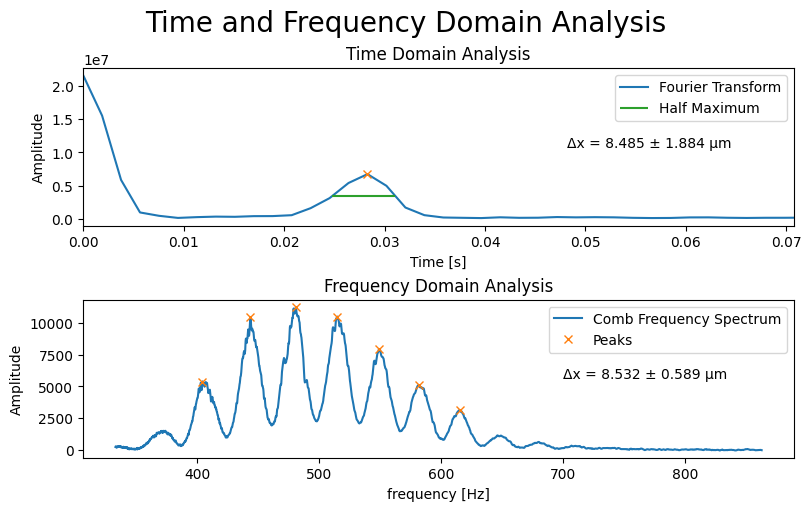

ΔxFP = 8.532 ± 0.589 μm
ΔxFT = 8.485 ± 1.884 μm



In [110]:
file1 = r"interferometry_data\part1.xlsx"
# data1 = load_data(file1)
# peaks = find_peaks_comb(data1, threshold = 1000, width = 10, distance = 50)
# plot_comb(data1, peaks, type = 'freq')
# delta_x1, delta_x_err1 = culc_frec_spacing(data1, peaks, plot = False, toprint = True)

delta_xFT1, delta_xFT1_err, delta_xFP1, delta_xFP1_err = calc_file2(file1, plot = True, threshold = 2000, width = 10, distance = 50)
print('ΔxFP = {:.3f} ± {:.3f} μm'.format(delta_xFP1, delta_xFP1_err))
print('ΔxFT = {:.3f} ± {:.3f} μm\n'.format(delta_xFT1, delta_xFT1_err))

## 2.7 Quantify the Interferometer Translation

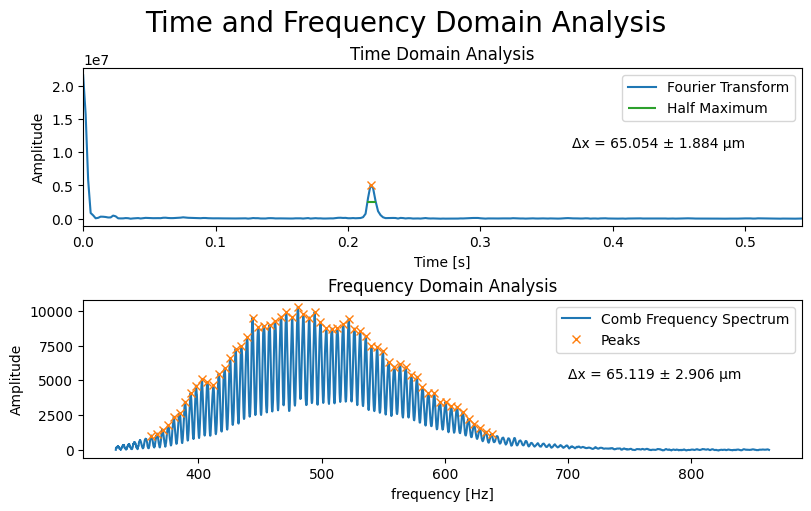

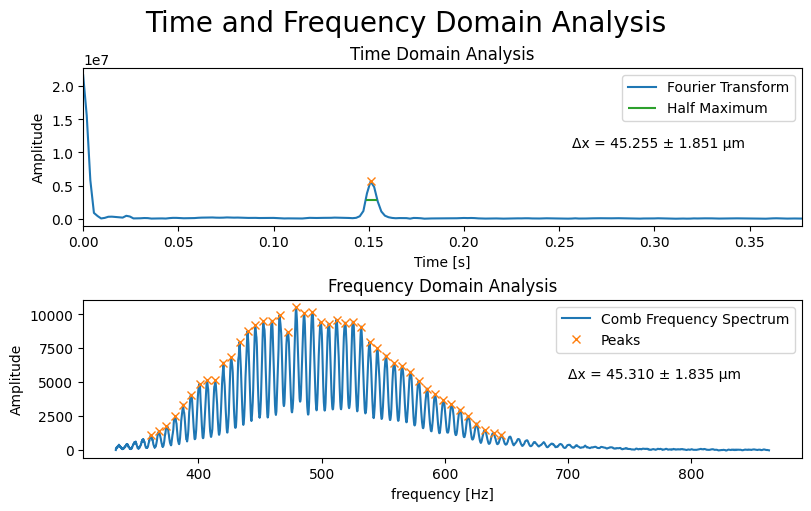

lFT2 = 56.569 ± 2.664 μm
lFP2 = 56.324 ± 2.994 μm

lFT3 = 36.770 ± 2.641 μm
lFP3 = 36.515 ± 1.971 μm


In [24]:
file2 = 'interferometry_data\part_2.xlsx'
file3 = 'interferometry_data\part1_2.xlsx'
delta_xFT2, delta_xFT2_err, delta_xFP2, delta_xFP2_err = calc_file2(file2, plot = True, width = 5, distance = 10)
delta_xFT3, delta_xFT3_err, delta_xFP3, delta_xFP3_err = calc_file2(file3, plot = True, width = 5, distance = 10)
# delta_x2, delta_x_err2 = calc_file(file2, plot1 = 'freq', width = 5, distance = 10)
# delta_x3, delta_x_err3 = calc_file(file3, plot1 = False)

lFT2 = delta_xFT2 - delta_xFT1
lFT3 = delta_xFT3 - delta_xFT1
lFT2_err = np.sqrt(delta_xFT1_err**2 + delta_xFT2_err**2)
lFT3_err = np.sqrt(delta_xFT1_err**2 + delta_xFT3_err**2)

lFP2 = delta_xFP2 - delta_xFP1
lFP3 = delta_xFP3 - delta_xFP1
lFP2_err = np.sqrt(delta_xFP1_err**2 + delta_xFP2_err**2)
lFP3_err = np.sqrt(delta_xFP1_err**2 + delta_xFP3_err**2)


print('lFT2 = {:.3f} ± {:.3f} μm'.format(lFT2, lFT2_err))
print('lFP2 = {:.3f} ± {:.3f} μm\n'.format(lFP2, lFP2_err))

print('lFT3 = {:.3f} ± {:.3f} μm'.format(lFT3, lFT3_err))
print('lFP3 = {:.3f} ± {:.3f} μm'.format(lFP3, lFP3_err))

## 2.8 Intensity Modulation of the Arms

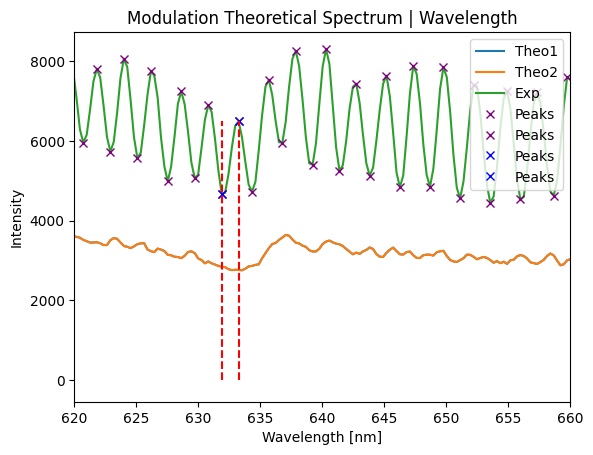

,type,exp,theo
0,max,6490.892398,2766.822692
1,min,4674.435663,2753.871067
2,mod,1.388594,726771.023689


mod_theo = 726771.024
mod_exp = 1.389


In [94]:
mod_theo1_file = 'interferometry_data/mod_theo1.xlsx'
mod_theo2_file = 'interferometry_data/mod_theo2.xlsx'
mod_exp_file = 'interferometry_data/modexp.xlsx'
data_mod_theo1 = load_data(mod_theo1_file)
data_mod_theo2 = load_data(mod_theo2_file)
data_mod_exp = load_data(mod_exp_file)
max_peaks_exp, _ = find_peaks(data_mod_exp['intensity'], height = 4000, distance = 1, width = 1)
min_peaks_exp, _ = find_peaks(-data_mod_exp['intensity'] ,distance = 1, width = 1)

# mod_theo_resulutsFP = calc_file(mod_theo1_file, plot1 = 'wavel', plot2 = True, width = 4, distance = 60)
plt.plot(data_mod_theo1['wavelength nm'], data_mod_theo1['intensity'], label = 'Theo1')
plt.plot(data_mod_theo1['wavelength nm'], data_mod_theo1['intensity'], label = 'Theo2')
plt.plot(data_mod_exp['wavelength nm'], data_mod_exp['intensity'], label = 'Exp')

plt.plot(data_mod_exp['wavelength nm'][max_peaks_exp], data_mod_exp['intensity'][max_peaks_exp], 'x', label = 'Peaks', color = 'purple') # max of exp
plt.plot(data_mod_exp['wavelength nm'][min_peaks_exp], data_mod_exp['intensity'][min_peaks_exp], 'x', label = 'Peaks', color = 'purple') # min of exp

n =56
m =153

plt.plot(data_mod_exp['wavelength nm'][max_peaks_exp[n]], data_mod_exp['intensity'][max_peaks_exp[n]], 'x', label = 'Peaks', color = 'blue')
plt.plot(data_mod_exp['wavelength nm'][min_peaks_exp[m]], data_mod_exp['intensity'][min_peaks_exp[m]], 'x', label = 'Peaks', color = 'blue')

# plt.plot(data_mod_theo1['wavelength nm'][max_peaks_exp[m]], data_mod_theo1['intensity'][max_peaks_exp[m]], 'x', label = 'Peaks', color = 'blue')

plt.vlines(data_mod_exp['wavelength nm'][max_peaks_exp[n]], 0, data_mod_exp['intensity'][max_peaks_exp[n]], color = 'r', linestyle = '--')
plt.vlines(data_mod_exp['wavelength nm'][min_peaks_exp[m]], 0, data_mod_exp['intensity'][max_peaks_exp[n]], color = 'r', linestyle = '--')

plt.xlabel('Wavelength [nm]')
plt.ylabel('Intensity')
plt.title('Modulation Theoretical Spectrum | Wavelength')
plt.xlim(620,660)
plt.legend()
plt.show()
# mod_theo_resuluts = calc_file2(mod_theo1_file, plot = True, width = 1, distance = 1)
I1 = data_mod_theo1['intensity'][max_peaks_exp[n]]
I2 = data_mod_theo2['intensity'][max_peaks_exp[n]]
mod_theo = (np.sqrt(I1) + np.sqrt(I2)) ** 2 / (np.sqrt(I1) - np.sqrt(I2)) ** 2
mod_exp = data_mod_exp['intensity'][max_peaks_exp[n]] / data_mod_exp['intensity'][min_peaks_exp[m]]
df = pd.DataFrame({'type':['max','min','mod']\
                   ,'exp': [data_mod_exp['intensity'][max_peaks_exp[n]], data_mod_exp['intensity'][min_peaks_exp[m]], mod_exp],\
                    'theo': [I1, I2, mod_theo]})
display(df)

print('mod_theo = {:.3f}'.format(mod_theo))
print('mod_exp = {:.3f}'.format(mod_exp))

## 2.9 Demonstrate the Law of Energy Conservation


In [ ]:
file_energy1 = '434DH.tab'
file_energy2 = '434DH.tab'
data_energy1 = load_data(file_energy1)
data_energy2 = load_data(file_energy2)

plt.plot(data_energy1['wavelength nm'], data_energy1['intensity'], label = 'interference pattern #1')
plt.plot(data_energy2['wavelength nm'], data_energy2['intensity'], label = 'interference pattern #2')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Intensity')
plt.title('Interference Patterns - Energy conservation')
plt.legend()
plt.show()

## 2.10 Measure the Index of Refraction of a Solid Sample

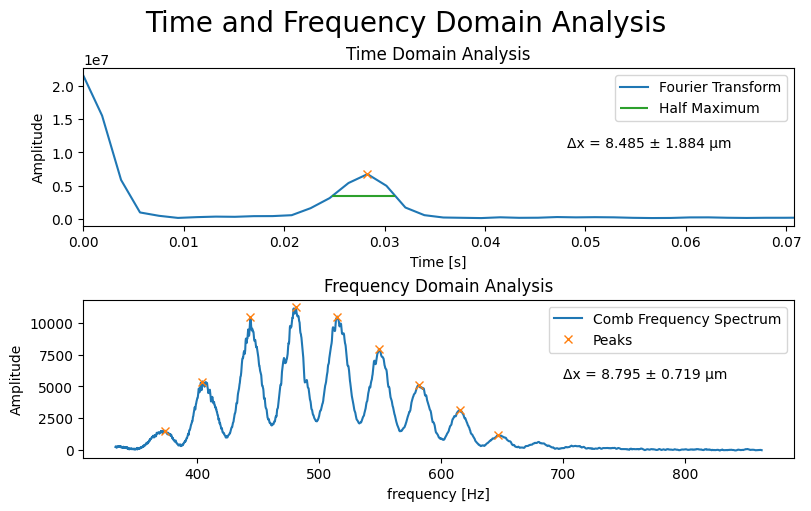

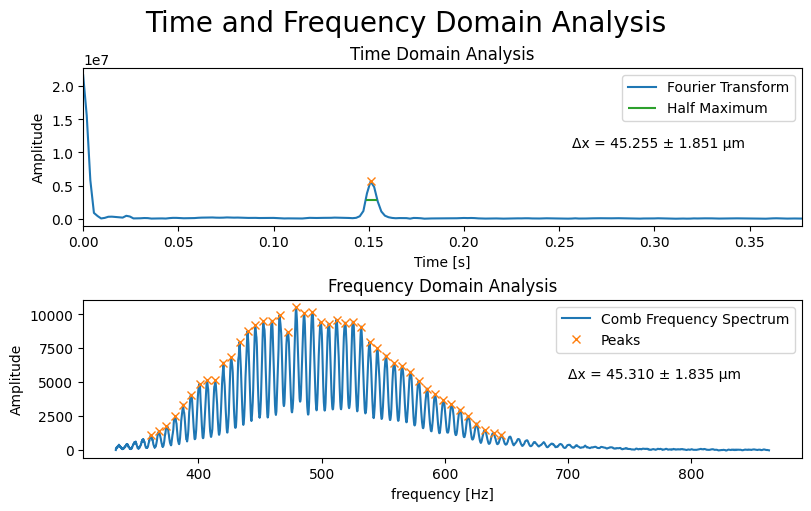

l_FT = 36.770 ± 2.641 μm
l_FP = 36.515 ± 1.971 μm

Δn_FT = 0.102 ± 0.007
Δn_FP = 0.101 ± 0.005

n_FT = 1.102 ± 0.007
n_FP = 1.101 ± 0.005


In [105]:
reference_file = 'interferometry_data/part1.xlsx'
mesure_file = 'interferometry_data/part1_2.xlsx'
d = 180 # sample thickness in um 
res = extract_reflective_index(mesure_file, reference_file, d, plot = True, width = 5, distance = 10)

## 2.11 Measure the Index of Refraction Dependence on the Concentration of a Solution

### Sucrose

In [ ]:
concentration_file = os.path.join("interferometry_data","conc_interferometer.xlsx")
concentration_data = pd.read_excel(concentration_file, sheet_name= 'sucrose - py')
data_folder = os.path.join('interferometry_data','sucrose')
reference_file = 'reference_sucrose.xlsx'
d = 1e6 # cuvettes thickness in um

nFT_list = []
nFT_err_list = []
nFP_list = []
nFP_err_list = []

for file in concentration_data['file_name']:
    file_path = os.path.join(data_folder, file)
    n_FT, n_FT_err, n_FP, n_FP_err = extract_reflective_index(file_path, reference_file, d, plot = False)
    nFT_list.append(n_FT)
    nFT_err_list.append(n_FT_err)
    nFP_list.append(n_FP)
    nFP_err_list.append(n_FP_err)

concentration_data['nFT'] = nFT_list
concentration_data['nFT_err'] = nFT_err_list
concentration_data['nFP'] = nFP_list
concentration_data['nFP_err'] = nFP_err_list
display(concentration_data)

plt.errorbar(concentration_data['concentration'], concentration_data['nFT'], yerr=concentration_data['nFT_err'], fmt='.', label = 'FT', capsize=5)
plt.errorbar(concentration_data['concentration'], concentration_data['nFP'], yerr=concentration_data['nFP_err'], fmt='.', label= 'FP', capsize=5)
plt.xlabel('Concentration [M]')
plt.ylabel('Refractive Index')
plt.title('Refractive Index vs. Concentration | Sucrose')
plt.show()


### Ethanol

In [ ]:
concentration_file = os.path.join("interferometry_data","conc_interferometer.xlsx")
concentration_data = pd.read_excel(concentration_file, sheet_name= 'ethanol - py')
data_folder = os.path.join('interferometry_data','ethanol')
reference_file = 'reference_ethanol.xlsx'
d = 1e6 # cuvettes thickness in um

nFT_list = []
nFT_err_list = []
nFP_list = []
nFP_err_list = []

for file in concentration_data['file_name']:
    file_path = os.path.join(data_folder, file)
    n_FT, n_FT_err, n_FP, n_FP_err = extract_reflective_index(file_path, reference_file, d, plot = False)
    nFT_list.append(n_FT)
    nFT_err_list.append(n_FT_err)
    nFP_list.append(n_FP)
    nFP_err_list.append(n_FP_err)

concentration_data['nFT'] = nFT_list
concentration_data['nFT_err'] = nFT_err_list
concentration_data['nFP'] = nFP_list
concentration_data['nFP_err'] = nFP_err_list
display(concentration_data)

plt.errorbar(concentration_data['concentration'], concentration_data['nFT'], yerr=concentration_data['nFT_err'], fmt='.', label = 'FT', capsize=5)
plt.errorbar(concentration_data['concentration'], concentration_data['nFP'], yerr=concentration_data['nFP_err'], fmt='.', label= 'FP', capsize=5)
plt.xlabel('Concentration [M]')
plt.ylabel('Refractive Index')
plt.title('Refractive Index vs. Concentration | Ethanol')
plt.show()
